In [ ]:
import numpy as np
import pandas as pd
import time
import multiprocessing
import psutil
import matplotlib.pyplot as plt

In [ ]:
NUM_NODES = 10
NUM_SOURCES = 3
NUM_HOURS = 24

In [ ]:
chromosome_length = NUM_NODES * NUM_SOURCES * NUM_HOURS


In [ ]:
def load_data(filepath):
    df = pd.read_csv(filepath)

    demand_pivot = df.pivot_table(index='Hour', columns='Node', values='Demand_kW', aggfunc='mean')
    demand_data = demand_pivot.fillna(0).to_numpy()  # Fill missing values if any

    NUM_HOURS = df['Hour'].nunique()
    unique_sources = df['Source'].unique()
    source_mapping = {name: idx for idx, name in enumerate(unique_sources)}
    NUM_SOURCES = len(source_mapping)

    capacity_data = np.zeros((NUM_HOURS, NUM_SOURCES))
    cost_data = np.zeros((NUM_HOURS, NUM_SOURCES))

    for hour in range(NUM_HOURS):
        for source_name, source_idx in source_mapping.items():
            filtered = df[(df['Hour'] == hour) & (df['Source'] == source_name)]
            if not filtered.empty:
                capacity_data[hour, source_idx] = filtered['Capacity_kW'].mean()
                cost_data[hour, source_idx] = filtered['Cost_per_kWh'].mean()

    return demand_data, capacity_data, cost_data, source_mapping

In [ ]:
data_filepath = "dataset.csv"
demand_data, capacity_data, cost_data, source_mapping = load_data(data_filepath)



print("Demand shape:", demand_data.shape)
print("Capacity shape:", capacity_data.shape)
print("Cost shape:", cost_data.shape)
print("Source mapping:", source_mapping)


Demand shape: (24, 10)
Capacity shape: (24, 3)
Cost shape: (24, 3)
Source mapping: {'Solar': 0, 'Wind': 1, 'Grid': 2}


In [ ]:
def fitness_function(chromosome, demand, capacity, cost, line_loss_factor=0.03, max_line_loss_ratio=0.05):
    allocation = chromosome.reshape((NUM_HOURS, NUM_NODES, NUM_SOURCES))

    total_cost = np.sum(allocation * cost[:, np.newaxis, :])

    total_demand = np.sum(demand)
    total_supplied = np.sum(allocation)
    demand_satisfaction_penalty = max(0, total_demand - total_supplied) * 1000

    energy_wastage_penalty = max(0, total_supplied - total_demand) * 1000


    capacity_penalty = 0
    for t in range(NUM_HOURS):
        for s in range(NUM_SOURCES):
            supplied_from_source = np.sum(allocation[t, :, s])
            if supplied_from_source > capacity[t, s]:
                capacity_penalty += (supplied_from_source - capacity[t, s]) * 1000

    line_loss = total_supplied * line_loss_factor
    max_allowed_line_loss = total_supplied * max_line_loss_ratio
    line_loss_penalty = 0
    if line_loss > max_allowed_line_loss:
        line_loss_penalty = (line_loss - max_allowed_line_loss) * 1000

    #final fitness score (lower is better)
    fitness = total_cost + demand_satisfaction_penalty + energy_wastage_penalty + capacity_penalty + line_loss_penalty
    return fitness

In [ ]:
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, chromosome_length - 1)
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    return child

In [ ]:
def mutate(chromosome, mutation_rate=0.3, swap_rate=0.05):
    for i in range(chromosome_length):
        if np.random.rand() < mutation_rate:
            chromosome[i] = np.random.rand() * 1.5
    if np.random.rand() < swap_rate:
        idx1, idx2 = np.random.choice(chromosome_length, 2, replace=False)
        chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome

In [ ]:
def select_parents(population, fitness_scores, num_parents):
    # Tournament selection: select two random individuals and pick the better one
    parents = np.empty((num_parents, chromosome_length))
    for i in range(num_parents):
        idx1, idx2 = np.random.choice(len(population), 2, replace=False)
        if fitness_scores[idx1] < fitness_scores[idx2]:
            parents[i, :] = population[idx1, :]
        else:
            parents[i, :] = population[idx2, :]
    return parents

In [ ]:
def get_cpu_usage():
    return psutil.cpu_percent(interval=None)

In [ ]:
def create_initial_population(population_size):
    return np.random.rand(population_size, chromosome_length)

In [ ]:
def genetic_algorithm_serial(population_size, generations, mutation_rate, demand_data, capacity_data, cost_data):
    population = create_initial_population(population_size)
    best_fitness_history = []
    cpu_usage_history = []

    for generation in range(generations):
        cpu_usage_history.append(get_cpu_usage())
        fitness_scores = np.array([fitness_function(chromo, demand_data, capacity_data, cost_data) for chromo in population])

        num_parents = population_size // 2
        parents = select_parents(population, fitness_scores, num_parents)

        next_population = []
        for i in range(population_size - num_parents):
            parent1, parent2 = parents[np.random.choice(num_parents, 2, replace=False)]
            child = crossover(parent1, parent2)
            mutated_child = mutate(child, mutation_rate)
            next_population.append(mutated_child)

        next_population.extend(parents)
        population = np.array(next_population)

        best_fitness = np.min(fitness_scores)
        best_fitness_history.append(best_fitness)
        print(f"Serial GA - Generation {generation}: Best Fitness = {best_fitness:.2f}")

    best_chromosome_idx = np.argmin(fitness_scores)
    best_chromosome = population[best_chromosome_idx]
    return best_chromosome, best_fitness_history, cpu_usage_history

In [ ]:
def _evaluate_chromosome(chromosome, demand, capacity, cost):
    return fitness_function(chromosome, demand, capacity, cost)

In [ ]:
from concurrent.futures import ThreadPoolExecutor
def genetic_algorithm_parallel(population_size, generations, mutation_rate, demand_data, capacity_data, cost_data):
    population = create_initial_population(population_size)
    best_fitness_history = []
    cpu_usage_history = []

    with ThreadPoolExecutor() as executor:
        for generation in range(generations):
            cpu_usage_history.append(get_cpu_usage())
            fitness_scores = list(executor.map(lambda chromo: fitness_function(chromo, demand_data, capacity_data, cost_data), population))
            fitness_scores = np.array(fitness_scores)

            num_parents = population_size // 2
            parents = select_parents(population, fitness_scores, num_parents)

            next_population = []
            for i in range(population_size - num_parents):
                parent1, parent2 = parents[np.random.choice(num_parents, 2, replace=False)]
                child = crossover(parent1, parent2)
                mutated_child = mutate(child, mutation_rate)
                next_population.append(mutated_child)

            next_population.extend(parents)
            population = np.array(next_population)

            best_fitness = np.min(fitness_scores)
            best_fitness_history.append(best_fitness)
            print(f"Parallel GA - Generation {generation}: Best Fitness = {best_fitness:.2f}")

    best_chromosome_idx = np.argmin(fitness_scores)
    best_chromosome = population[best_chromosome_idx]
    return best_chromosome, best_fitness_history, cpu_usage_history

In [ ]:
def greedy_algorithm(demand_data, capacity_data, cost_data):
    allocation = np.zeros((NUM_HOURS, NUM_NODES, NUM_SOURCES))

    for t in range(NUM_HOURS):
        for n in range(NUM_NODES):
            remaining_demand = demand_data[t, n]

            source_costs_for_hour = []
            for s in range(NUM_SOURCES):
                source_costs_for_hour.append((cost_data[t, s], s))

            source_costs_for_hour.sort()

            for source_cost, s_idx in source_costs_for_hour:
                if remaining_demand <= 0:
                    break

                available_capacity = capacity_data[t, s_idx] - np.sum(allocation[t, :, s_idx])

                amount_to_allocate = min(remaining_demand, available_capacity)

                if amount_to_allocate > 0:
                    allocation[t, n, s_idx] = amount_to_allocate
                    remaining_demand -= amount_to_allocate

    greedy_fitness = fitness_function(allocation.flatten(), demand_data, capacity_data, cost_data)
    return allocation, greedy_fitness

In [ ]:
def plot_results(fitness_history_serial, fitness_history_parallel, greedy_fitness, cpu_usage_serial, cpu_usage_parallel,
                 time_serial, time_parallel, time_greedy,
                 best_chromosome_serial, best_chromosome_parallel, best_allocation_greedy,
                 demand_data, capacity_data, cost_data):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(12, 6))
    plt.plot(fitness_history_serial, label="Serial GA", color="#1f77b4", linewidth=2, marker='o')
    plt.plot(fitness_history_parallel, label="Parallel GA", color="#2ca02c", linewidth=2, marker='s')
    plt.axhline(y=greedy_fitness, color="#d62728", linestyle="--", label="Greedy Algorithm", linewidth=2)
    plt.xlabel("Generation", fontsize=14)
    plt.ylabel("Fitness Score (Lower is Better)", fontsize=14)
    plt.title("Fitness Score Convergence", fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(cpu_usage_serial, label="Serial GA", color="#1f77b4", linewidth=2, marker='o')
    plt.plot(cpu_usage_parallel, label="Parallel GA", color="#2ca02c", linewidth=2, marker='s')
    plt.xlabel("Generation", fontsize=14)
    plt.ylabel("CPU Usage (%)", fontsize=14)
    plt.title("CPU Usage Over Generations", fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    bars = plt.bar(['Serial GA', 'Parallel GA', 'Greedy'], [time_serial, time_parallel, time_greedy], color=["#1f77b4", "#2ca02c", "#d62728"] )
    plt.ylabel('Execution Time (seconds)', fontsize=14)
    plt.title('Execution Time Comparison', fontsize=16, fontweight='bold')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    greedy_cost = greedy_fitness
    serial_cost = min(fitness_history_serial)
    parallel_cost = min(fitness_history_parallel)
    improvement_serial = greedy_cost - serial_cost
    improvement_parallel = greedy_cost - parallel_cost
    percent_serial = (improvement_serial / greedy_cost) * 100 if greedy_cost != 0 else 0
    percent_parallel = (improvement_parallel / greedy_cost) * 100 if greedy_cost != 0 else 0
    plt.figure(figsize=(8, 5))
    bars = plt.bar(['Serial GA', 'Parallel GA'], [improvement_serial, improvement_parallel], color=["#1f77b4", "#2ca02c"] )
    plt.ylabel('Cost Improvement vs Greedy', fontsize=14)
    plt.title('Cost Improvement over Greedy Algorithm', fontsize=16, fontweight='bold')
    for i, bar in enumerate(bars):
        percent = percent_serial if i == 0 else percent_parallel
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}\n({percent:.2f}%)', ha='center', va='bottom', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"Serial GA Cost Improvement over Greedy: {improvement_serial:.2f} ({percent_serial:.2f}%)")
    print(f"Parallel GA Cost Improvement over Greedy: {improvement_parallel:.2f} ({percent_parallel:.2f}%)")

    allocation_serial = best_chromosome_serial.reshape(demand_data.shape[0], demand_data.shape[1], len(cost_data[0]))
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(np.sum(allocation_serial, axis=2), cmap='YlGnBu', annot=False, cbar_kws={'label': 'Total Energy Allocated (kW)'})
    plt.xlabel('Node', fontsize=14)
    plt.ylabel('Hour', fontsize=14)
    plt.title('Serial GA: Total Energy Allocation per Node per Hour', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(np.sum(allocation_serial, axis=1), cmap='magma', annot=False, cbar_kws={'label': 'Total Energy from Source (kW)'})
    plt.xlabel('Source', fontsize=14)
    plt.ylabel('Hour', fontsize=14)
    plt.title('Serial GA: Source Utilization per Hour', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    total_cost_per_hour = np.sum(allocation_serial * cost_data[:, np.newaxis, :], axis=(1,2))
    total_demand_per_hour = np.sum(demand_data, axis=1)
    plt.figure(figsize=(12, 6))
    plt.plot(total_cost_per_hour, label='Total Cost per Hour', color="#d62728", linewidth=2, marker='o')
    plt.plot(total_demand_per_hour, label='Total Demand per Hour', color="#1f77b4", linewidth=2, marker='s')
    plt.xlabel('Hour', fontsize=14)
    plt.ylabel('kW / Cost', fontsize=14)
    plt.title('Serial GA: Cost vs Demand per Hour', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    allocation_parallel = best_chromosome_parallel.reshape(demand_data.shape[0], demand_data.shape[1], len(cost_data[0]))

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(np.sum(allocation_parallel, axis=2), cmap='YlGnBu', annot=False, cbar_kws={'label': 'Total Energy Allocated (kW)'})
    plt.xlabel('Node', fontsize=14)
    plt.ylabel('Hour', fontsize=14)
    plt.title('Parallel GA: Total Energy Allocation per Node per Hour', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(np.sum(allocation_parallel, axis=1), cmap='magma', annot=False, cbar_kws={'label': 'Total Energy from Source (kW)'})
    plt.xlabel('Source', fontsize=14)
    plt.ylabel('Hour', fontsize=14)
    plt.title('Parallel GA: Source Utilization per Hour', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    total_cost_per_hour_parallel = np.sum(allocation_parallel * cost_data[:, np.newaxis, :], axis=(1,2))
    plt.figure(figsize=(12, 6))
    plt.plot(total_cost_per_hour_parallel, label='Total Cost per Hour', color="#d62728", linewidth=2, marker='o')
    plt.plot(total_demand_per_hour, label='Total Demand per Hour', color="#1f77b4", linewidth=2, marker='s')
    plt.xlabel('Hour', fontsize=14)
    plt.ylabel('kW / Cost', fontsize=14)
    plt.title('Parallel GA: Cost vs Demand per Hour', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    bars = plt.bar(['Serial GA', 'Parallel GA', 'Greedy'], [serial_cost, parallel_cost, greedy_cost], color=["#1f77b4", "#2ca02c", "#d62728"] )
    plt.ylabel('Best Fitness Score (Lower is Better)', fontsize=14)
    plt.title('Best Fitness Score Comparison', fontsize=16, fontweight='bold')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


--- Running Serial Genetic Algorithm ---
Serial GA - Generation 0: Best Fitness = 13849698.15
Serial GA - Generation 1: Best Fitness = 13790432.05
Serial GA - Generation 2: Best Fitness = 13750096.15
Serial GA - Generation 3: Best Fitness = 13730377.64
Serial GA - Generation 4: Best Fitness = 13715457.59
Serial GA - Generation 5: Best Fitness = 13695903.16
Serial GA - Generation 6: Best Fitness = 13682417.53
Serial GA - Generation 7: Best Fitness = 13672814.43
Serial GA - Generation 8: Best Fitness = 13671110.02
Serial GA - Generation 9: Best Fitness = 13657162.26
Serial GA - Generation 10: Best Fitness = 13664459.11
Serial GA - Generation 11: Best Fitness = 13664459.11
Serial GA - Generation 12: Best Fitness = 13661854.22
Serial GA - Generation 13: Best Fitness = 13660327.93
Serial GA - Generation 14: Best Fitness = 13655007.04
Serial GA - Generation 15: Best Fitness = 13658033.33
Serial GA - Generation 16: Best Fitness = 13655192.55
Serial GA - Generation 17: Best Fitness = 13653295

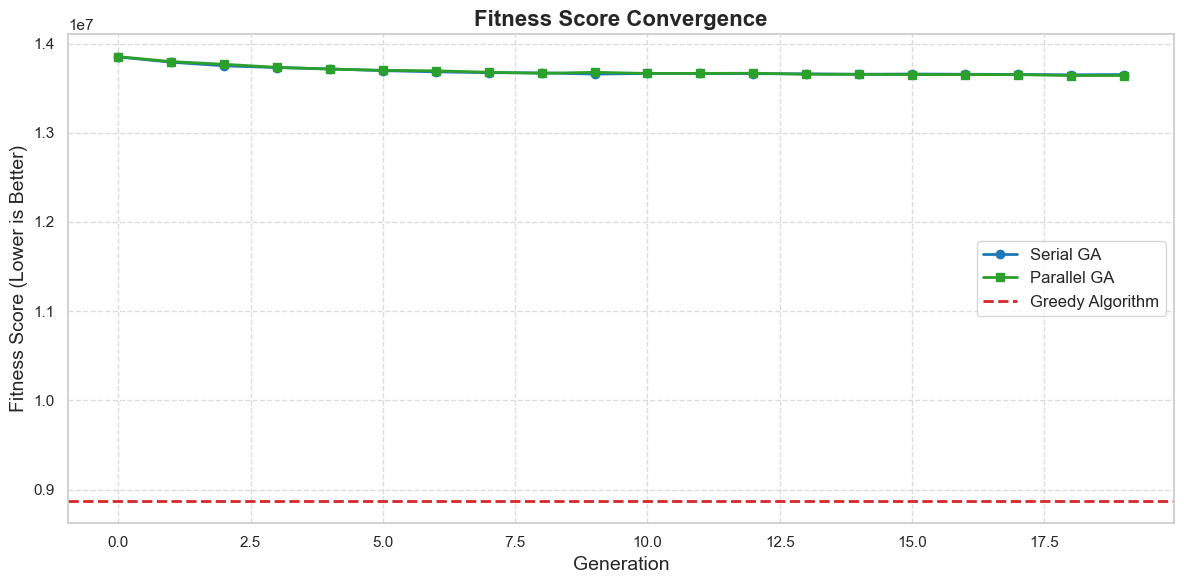

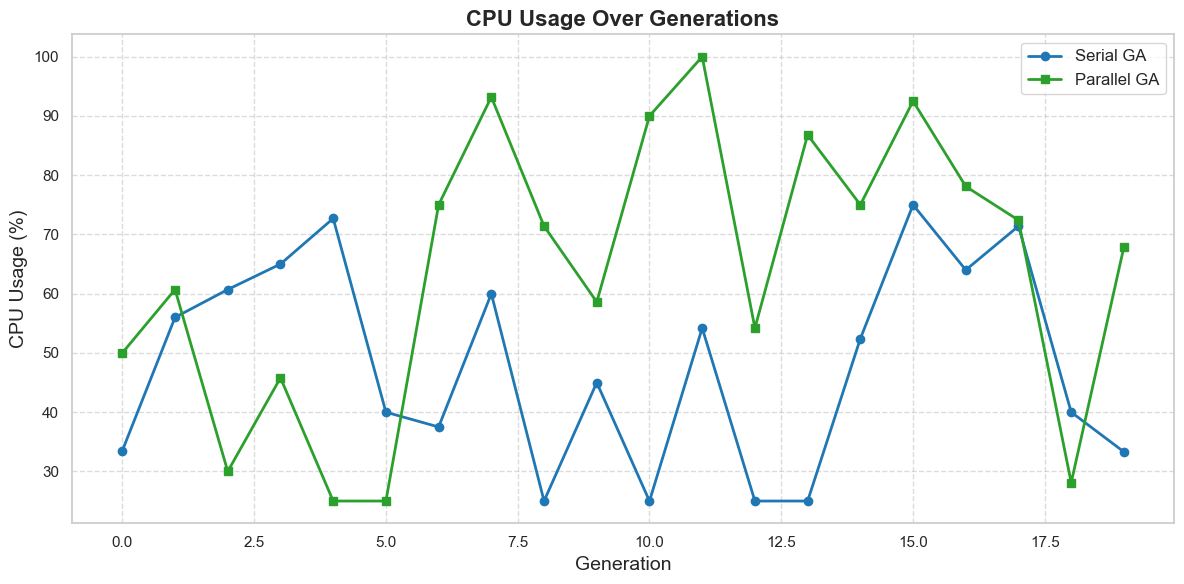

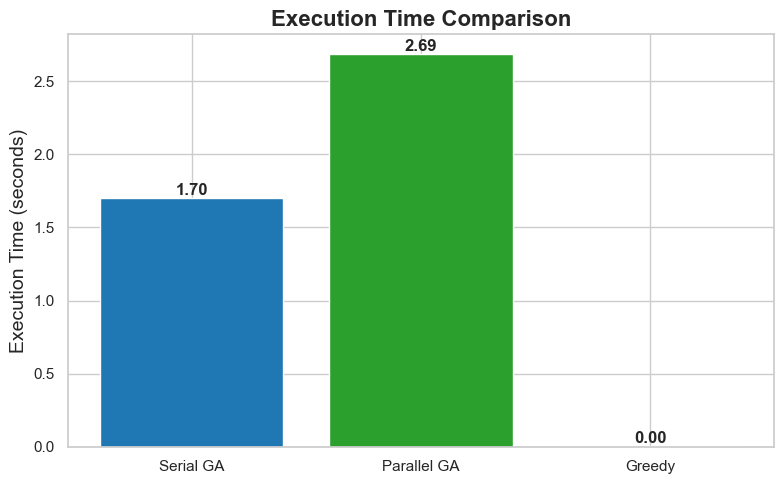

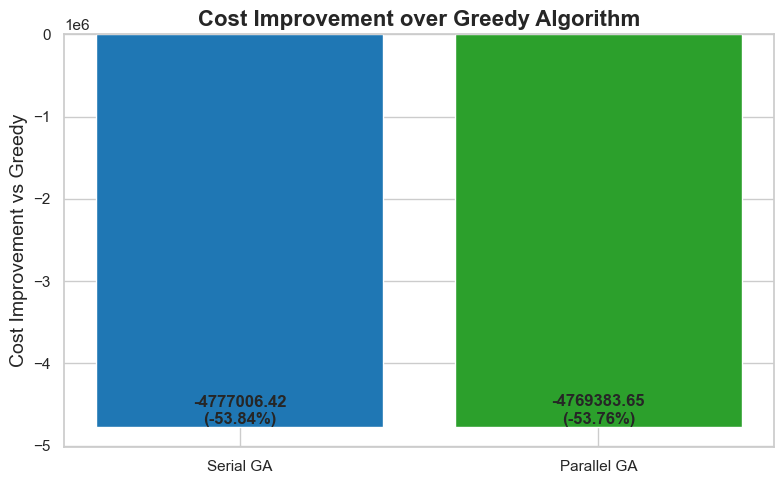

Serial GA Cost Improvement over Greedy: -4777006.42 (-53.84%)
Parallel GA Cost Improvement over Greedy: -4769383.65 (-53.76%)


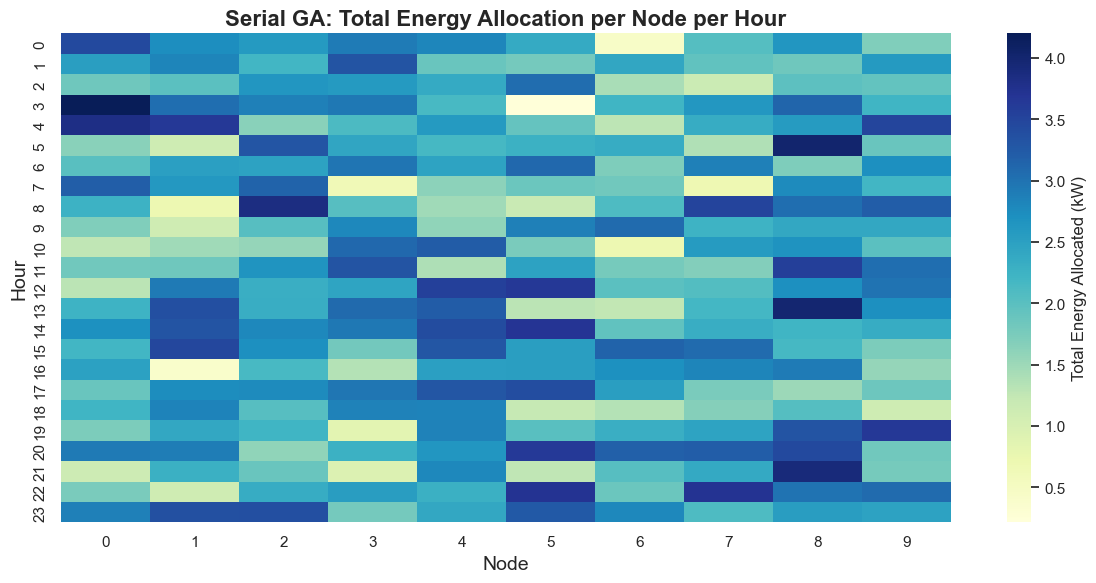

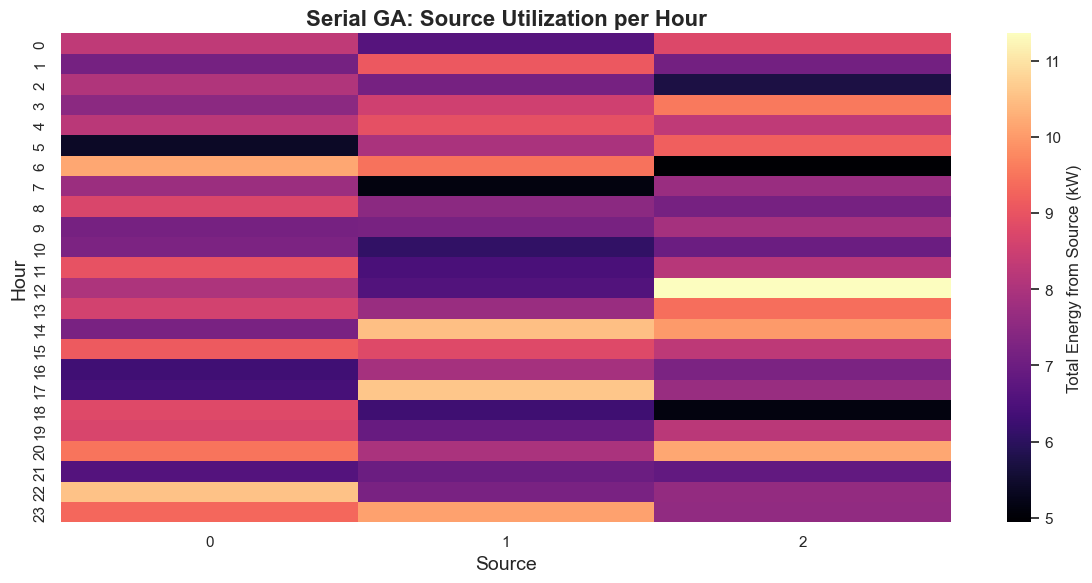

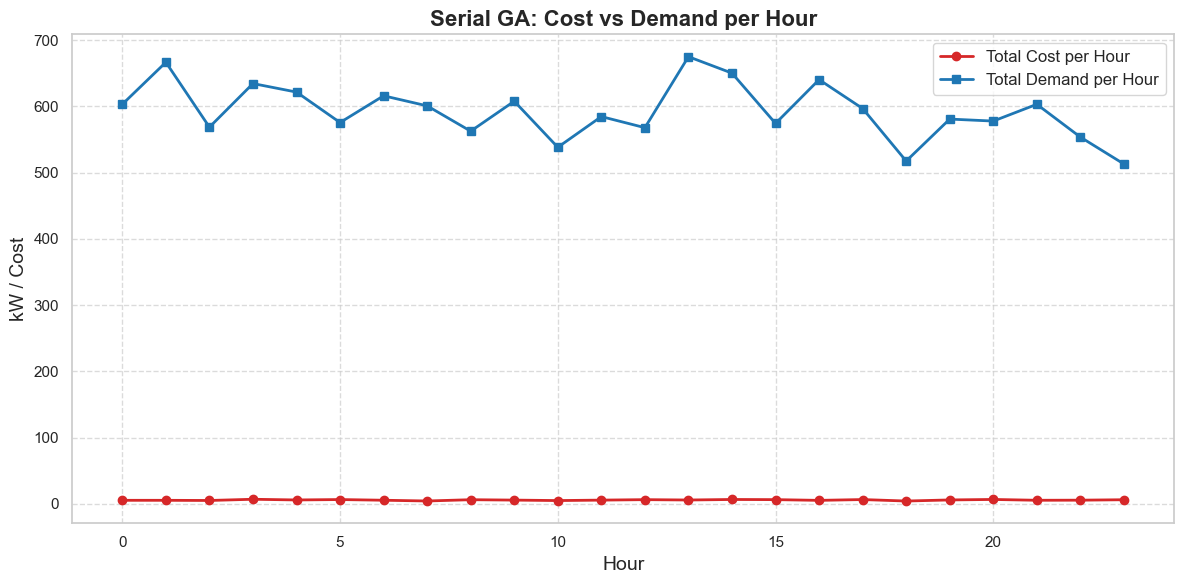

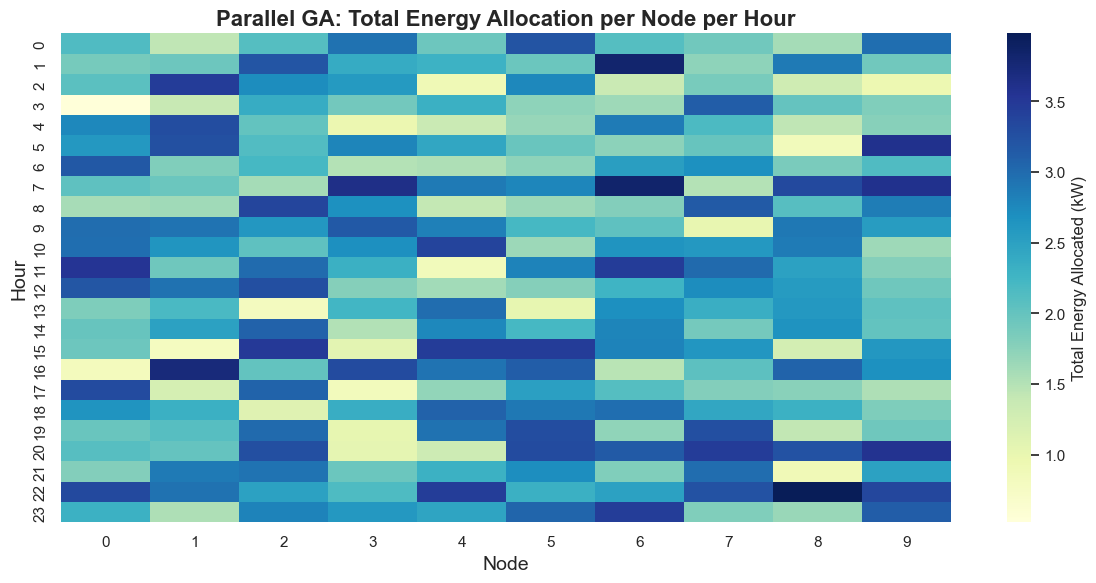

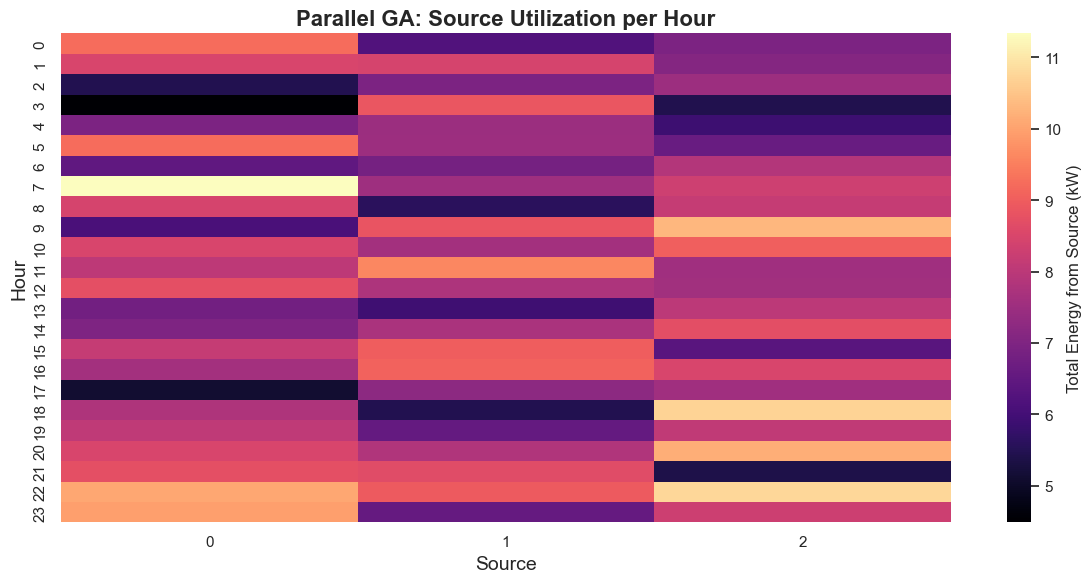

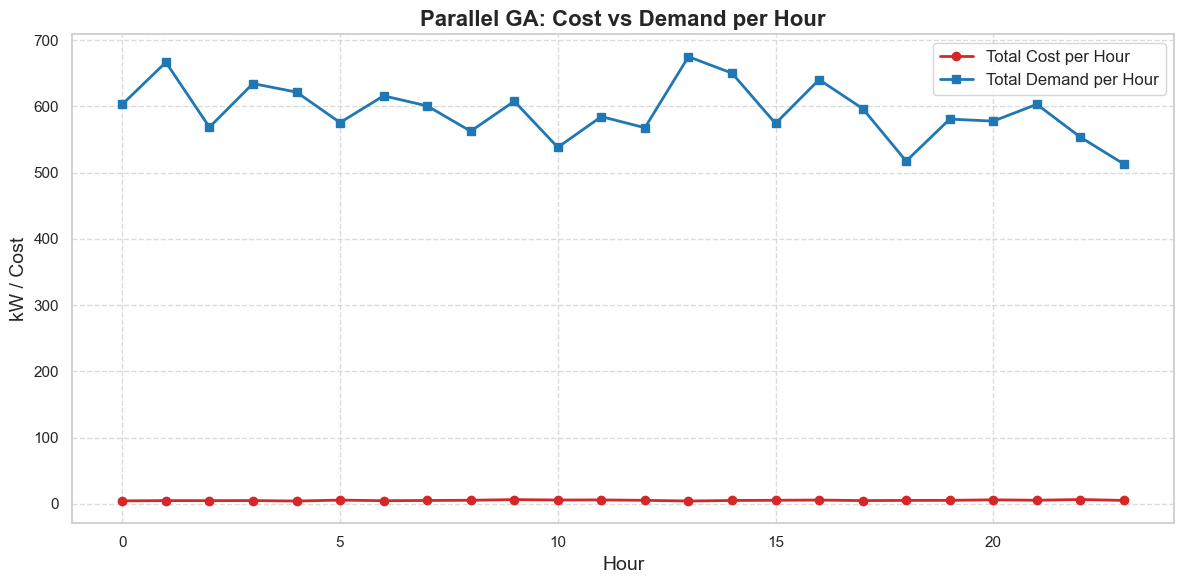

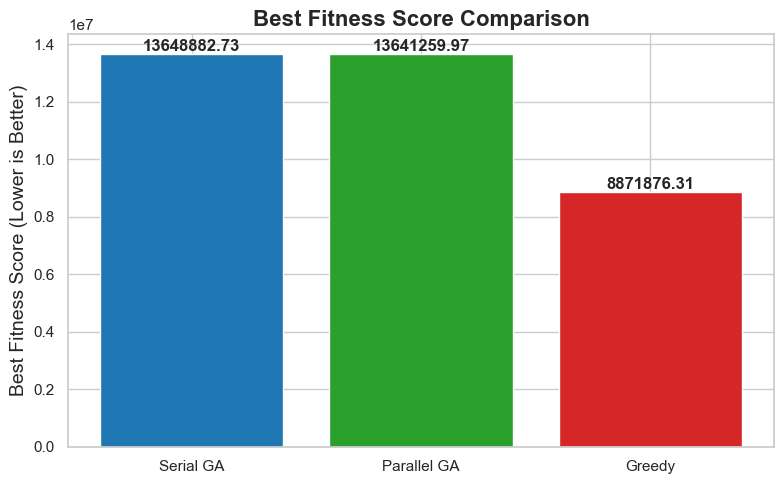

All algorithms executed and plots generated.


In [ ]:
if __name__ == "__main__":
    # Genetic Algorithm Parameters
    population_size = 100
    generations = 20
    mutation_rate = 0.3

    print("\n--- Running Serial Genetic Algorithm ---")
    start_time_serial = time.time()
    best_chromosome_serial, fitness_history_serial, cpu_usage_serial = genetic_algorithm_serial(population_size, generations, mutation_rate, demand_data, capacity_data, cost_data)
    end_time_serial = time.time()
    time_serial = end_time_serial - start_time_serial
    print(f"Serial GA Training Time: {time_serial:.2f} seconds")

    print("\n--- Running Parallel Genetic Algorithm ---")
    start_time_parallel = time.time()
    best_chromosome_parallel, fitness_history_parallel, cpu_usage_parallel = genetic_algorithm_parallel(population_size, generations, mutation_rate, demand_data, capacity_data, cost_data)
    end_time_parallel = time.time()
    time_parallel = end_time_parallel - start_time_parallel
    print(f"Parallel GA Training Time: {time_parallel:.2f} seconds")

    print("\n--- Running Greedy Algorithm ---")
    start_time_greedy = time.time()
    best_allocation_greedy, greedy_fitness = greedy_algorithm(demand_data, capacity_data, cost_data)
    end_time_greedy = time.time()
    time_greedy = end_time_greedy - start_time_greedy
    print(f"Greedy Algorithm Training Time: {time_greedy:.2f} seconds")
    print(f"Greedy Algorithm Fitness: {greedy_fitness:.2f}")

    plot_results(
        fitness_history_serial, fitness_history_parallel, greedy_fitness,
        cpu_usage_serial, cpu_usage_parallel,
        time_serial, time_parallel, time_greedy,
        best_chromosome_serial, best_chromosome_parallel, best_allocation_greedy,
        demand_data, capacity_data, cost_data
    )

    print("All algorithms executed and plots generated.")